<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# Análise Exploratória de Dados com Python: Eleições de 2022 - Itapuí (SP)
Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/)<br>
01/12/2022

---

### **1. Contexto**


O tribunal superior eleitoral (TSE) disponibilizou os dados brutos das urnas de votação utilizadas durante o processo eleitoral de 2022. No site do TSE ([link](https://resultados.tse.jus.br/oficial/app/index.html#/eleicao/resultados)) encontra-se os seguintes dados para cada urna:


 - **Registro Digital do Voto (RDV)**: Registro unitário dos votos;
 - **Boletim de Urna**: Resultados agregados;
 - **Log de Urna**: Todos os eventos que ocorreram na urna.

A documentação técnica para o processamento dos arquivo também se encontra no website do TSE ([link](https://www.tse.jus.br/eleicoes/eleicoes-2022/documentacao-tecnica-do-software-da-urna-eletronica)).

> Para uma única urna (estado, cidade, zona e seção), vamos utilizar o **Python** para processar o seu arquivo **RDV** e replicar os valores agregados do seu **Boletim de Urna** para o segundo turno de votação para presidente do processo eleitoral de 2022.


## 2\. Exploração

Para os arquivos usados abaixo foi utilizado o código disponibilizado pelo TSE ([link](https://www.tse.jus.br/eleicoes/eleicoes-2022/documentacao-tecnica-do-software-da-urna-eletronica)) para descriptografar o arquivo RDV em arquivos de texto.

#### **2.1. Limpeza**

In [1]:
import re
import os

import pandas as pd
import seaborn as sns

In [2]:
#selecionando as linhas apenas para presidente e adcionando as seções correspondentes

content = []
for root, dirs, files in os.walk('.'):
    for file in files:
        if file.endswith('.txt'):
            with open(os.path.join(root, file), 'r') as fp:
                content.append(f"seção: {file[0:4]}")
                for line in fp.readlines():
                    if "Governador" in line:
                        break
                    else:
                        content.append(line)

for linha in content[0:10]:
    print(linha)

seção: 0010

----------------------------------------

Presidente

  1 - nominal  - [13]

  2 - nominal  - [13]

  3 - nominal  - [13]

  4 - nominal  - [13]

  5 - nominal  - [13]

  6 - nominal  - [13]



#### **2.2. Extração**

In [3]:
#extraindo os dados de votação

votes = []

for line in content:

  if 'seção' in line:

      secao = line.split()[1]

  if "branco" in line:

      votes.append({"secao": secao, "voto": "branco", "quantidade": 1})

  if "nulo" in line:

      votes.append({"secao": secao, "voto": "nulo", "quantidade": 1})

  if "nominal" in line:

      vote = re.findall(pattern="\[(.*?)\]", string=line)[0]
      votes.append({"secao": secao, "voto": f"{vote}", "quantidade": 1})

len(votes)

7904

In [4]:
for vote in votes[0:10]:
    print(vote)

{'secao': '0010', 'voto': '13', 'quantidade': 1}
{'secao': '0010', 'voto': '13', 'quantidade': 1}
{'secao': '0010', 'voto': '13', 'quantidade': 1}
{'secao': '0010', 'voto': '13', 'quantidade': 1}
{'secao': '0010', 'voto': '13', 'quantidade': 1}
{'secao': '0010', 'voto': '13', 'quantidade': 1}
{'secao': '0010', 'voto': '13', 'quantidade': 1}
{'secao': '0010', 'voto': '13', 'quantidade': 1}
{'secao': '0010', 'voto': '13', 'quantidade': 1}
{'secao': '0010', 'voto': '13', 'quantidade': 1}


## 3\. Processamento

In [30]:
df_v = pd.DataFrame(votes)

In [6]:
#organizando por seção e adionando soma e porcentagem dos votos
df = df_v.groupby(['secao', 'voto']).agg('sum')
df['pct'] = round(100 * (df['quantidade'] / df['quantidade'].groupby('secao').sum()), 2)
df.head(n=8)

quantidade    pct
secao voto                     
0010  13             104  39.69
      22             144  54.96
      branco           6   2.29
      nulo             8   3.05
0011  13             112  43.41
      22             128  49.61
      branco           7   2.71
      nulo            11   4.26

In [7]:
#soma e porcentagem da cidade toda
df_city = df_v.groupby('voto').agg('sum').reset_index()
df_city['pct'] = round(100 * (df_city['quantidade'] / df_city['quantidade'].sum()), 2)
df_city.sort_values(by='quantidade', ascending=False, inplace=True)
df_city

,voto,quantidade,pct
1,22,4360,55.16
0,13,3092,39.12
3,nulo,265,3.35
2,branco,187,2.37


## 4\. Visualização

##### **4.1 Votos por seções (Urnas)**

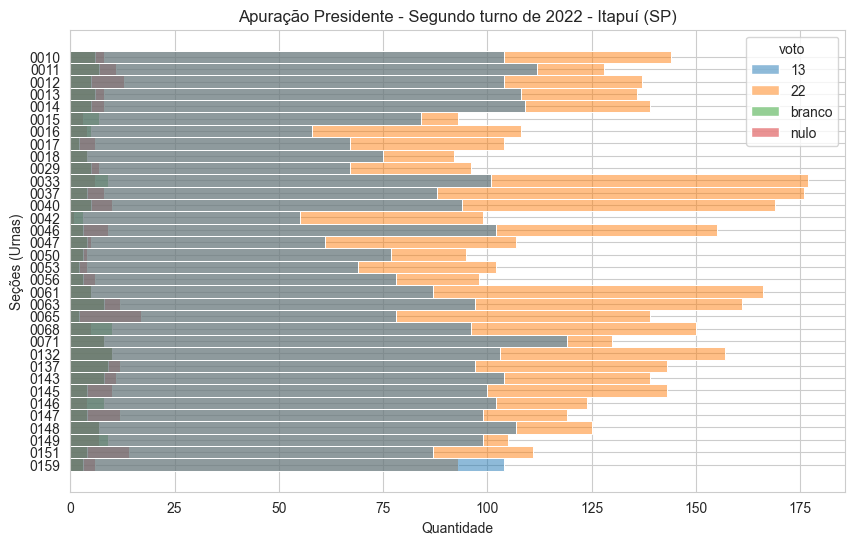

In [65]:
with sns.axes_style('whitegrid'):
  chart = sns.histplot(data=df_v, y="secao", hue='voto')
  chart.set(title='Apuração Presidente - Segundo turno de 2022 - Itapuí (SP)', xlabel='Quantidade', ylabel='Seções (Urnas)')
  chart.figure.set_size_inches(10,6)

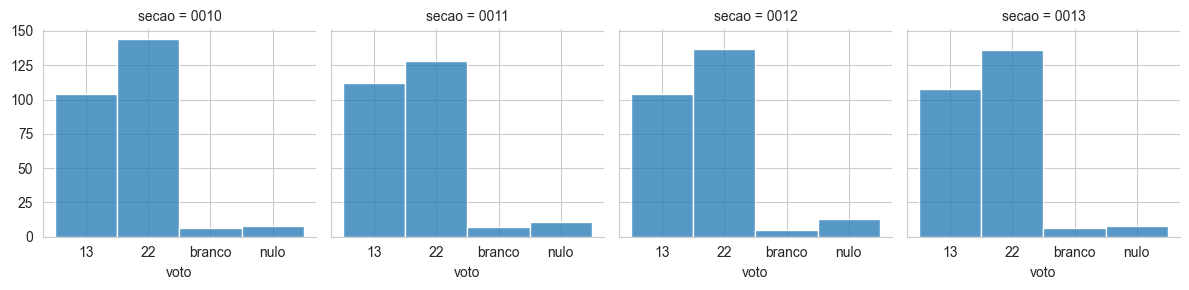

In [64]:
df_s = df_v.query('"0010" <= secao < "0014"')

with sns.axes_style('whitegrid'):

  grafico = sns.FacetGrid(data=df_s, col="secao",  hue="quantidade")
  grafico.map(sns.histplot, "voto")

##### **4.2 Votos totais do municipio**

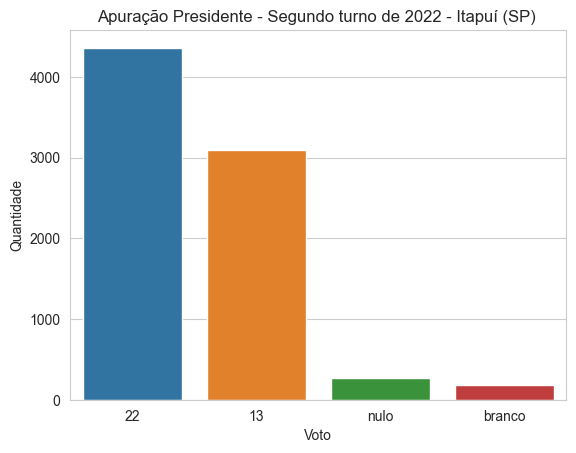

In [9]:
with sns.axes_style('whitegrid'):
  chart = sns.barplot(data=df_city, x='voto', y='quantidade')
  chart.set(title='Apuração Presidente - Segundo turno de 2022 - Itapuí (SP) ', xlabel='Voto', ylabel='Quantidade')

Text(0.5, 1.0, 'Apuração Presidente - Segundo turno de 2022 - Itapuí (SP)')

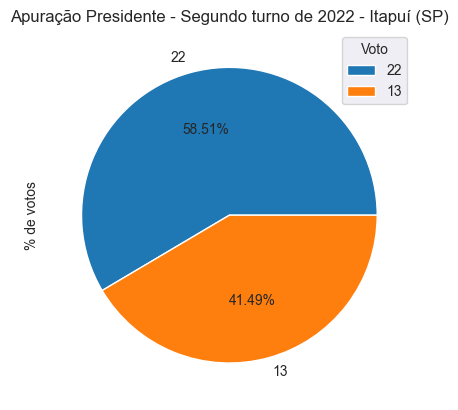

In [10]:
city = df_city.query('voto == "13" | voto == "22"')
city = city.plot.pie(y='pct', autopct='%1.2f%%', labels=df_city['voto'])
city.legend(title='Voto')
city.set_ylabel('% de votos')
city.set_title("Apuração Presidente - Segundo turno de 2022 - Itapuí (SP)")

#### Conclusão

Os resultados disponibilizados pelo site do TSE ([link](https://resultados.tse.jus.br/oficial/app/index.html#/divulga/votacao-nominal;e=545;cargo=1;uf=sp;mu=65595;zona=TODAS)) referente ao municipio de Itapuí-SP, são coerentes aos dados gerados pelas urnas.